# ResNet Implementation

In [1]:
from fastai.vision.all import *
from typing import List

In [2]:
url = URLs.IMAGEWOOF
path = untar_data(url)

In [3]:
BATCH_SIZE = 64
WEIGHT_DECAY = 1e-4

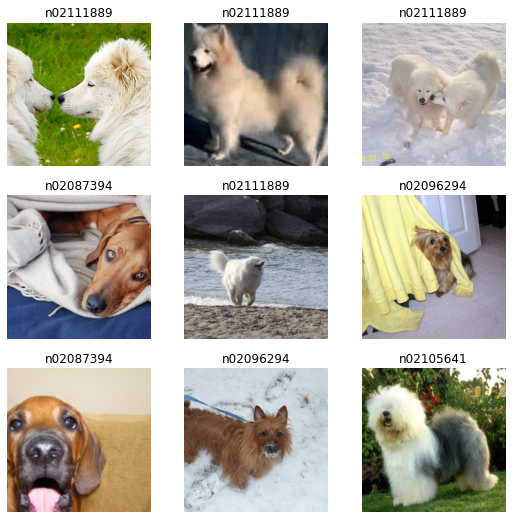

In [4]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter(train_name='train', valid_name='val'),
    item_tfms=Resize(460),
    batch_tfms=[*aug_transforms(size=(224, 224)), Normalize.from_stats(*imagenet_stats)]
)

dls = dblock.dataloaders(path, bs=BATCH_SIZE)
dls.show_batch()

In [5]:
class ConvBnRelu(nn.Module):
    
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int,
                 activation: bool = True, **kwargs):
        super().__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size,
                              padding=padding, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = noop
        if activation:
            self.activation = nn.ReLU()
    
    def forward(self, x: torch.Tensor):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        return x

In [6]:
class StandardBlock(nn.Module):
    
    def __init__(self, channels: int, stride: int = 1):
        super().__init__()
        in_channels = channels // stride
        self.conv1 = ConvBnRelu(in_channels, channels, kernel_size=3, stride=stride)
        self.conv2 = ConvBnRelu(channels, channels, kernel_size=3, activation=False)
                
        self.identity_proj = noop
        if stride != 1 or in_channels != channels:
            self.identity_proj = nn.Sequential(
                nn.Conv2d(in_channels, channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channels),
            )
        
    def forward(self, inp: torch.Tensor):
        out = self.conv1(inp)
        out = self.conv2(out)
        out = F.relu(out + self.identity_proj(inp))
        return out

In [7]:
class BottleneckBlock(nn.Module):
    
    def __init__(self, channels: int, stride: int = 1, downscaling: int = 4, upscaling: int = 4):
        super().__init__()
        in_channels  = channels * downscaling
        out_channels = channels * upscaling
        
        self.conv1 = ConvBnRelu(in_channels, channels, kernel_size=1, stride=stride)
        self.conv2 = ConvBnRelu(channels, channels, kernel_size=3)
        self.conv3 = ConvBnRelu(channels, out_channels, kernel_size=1, activation=False)
        
        self.identity_proj = noop
        if in_channels != out_channels:
            self.identity_proj = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
    
    def forward(self, inp: torch.Tensor):
        out = self.conv1(inp)
        out = self.conv2(out)
        out = self.conv3(out)
        out = F.relu(out + self.identity_proj(inp))
        return out

In [8]:
class ResNet(nn.Module):
    
    def __init__(self, structure: List[int], num_classes: int, use_bottleneck = True):
        super().__init__()
        self.use_bottleneck = use_bottleneck
        block = BottleneckBlock if self.use_bottleneck else StandardBlock
        
        initial_channels = 64
        final_channels = 2048 if self.use_bottleneck else 512
        
        self.conv1 = ConvBnRelu(3, initial_channels, kernel_size=7, stride=2)
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.conv2 = self.create_layer(block, count=structure[0], channels=64,  stride=1)
        self.conv3 = self.create_layer(block, count=structure[1], channels=128, stride=2)
        self.conv4 = self.create_layer(block, count=structure[2], channels=256, stride=2)
        self.conv5 = self.create_layer(block, count=structure[3], channels=512, stride=2)
                
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(final_channels, num_classes)
    
    def create_layer(self, block: nn.Module, count: int, channels: int, stride: int):
        blocks = []
        
        kwgs = {}
        if self.use_bottleneck:
            kwgs = {"downscaling": stride}
        
        blocks.append(block(channels, stride=stride, **kwgs))
        for _ in range(1, count):
            blocks.append(block(channels, stride=1))
        
        return nn.Sequential(*blocks)
        
    
    def forward(self, x: torch.Tensor):
        x = self.conv1(x)
        x = self.max_pool(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avg_pool(x).flatten(1)
        x = self.fc(x)
        return x

In [9]:
def resnet18(num_classes: int):
    structure = [2, 2, 2, 2]
    return ResNet(structure, num_classes, use_bottleneck=False)

def resnet34(num_classes: int):
    structure = [3, 4, 6, 3]
    return ResNet(structure, num_classes, use_bottleneck=False)

def resnet50(num_classes: int):
    structure = [3, 4, 6, 3]
    return ResNet(structure, num_classes, use_bottleneck=True)

def resnet101(num_classes: int):
    structure = [3, 4, 23, 3]
    return ResNet(structure, num_classes, use_bottleneck=True)

def resnet152(num_classes: int):
    structure = [3, 8, 36, 3]
    return ResNet(structure, num_classes, use_bottleneck=True)

In [10]:
model = resnet50(num_classes=dls.c)
learn = Learner(dls, model, wd=WEIGHT_DECAY, metrics=[accuracy])
learn.fit_one_cycle(50, 3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,2.249042,2.204214,0.182744,00:33
1,2.143756,2.165457,0.212777,00:32
2,2.055040,2.194137,0.209723,00:32
3,1.982678,1.927947,0.307203,00:32
4,1.906724,1.882282,0.311784,00:33
5,1.835265,1.800556,0.362179,00:31
6,1.743432,1.756630,0.378213,00:32
7,1.673762,1.754364,0.386103,00:32
8,1.526006,1.724740,0.417664,00:31
9,1.491561,1.810466,0.417918,00:31


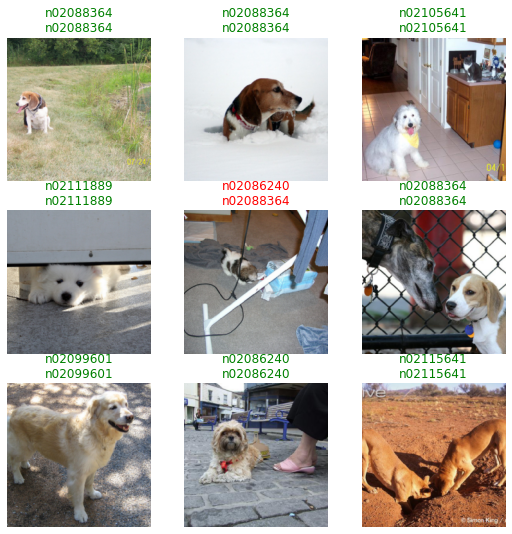

In [11]:
learn.show_results()